# Решающее дерево

Отметим, что решающее дерево состоит из вершин, в которых записывает некоторое условие, а в листах дерева - прогноз. Условия во внутренних вершинах выбираются простыми. Наиболее частый вариант - проверка лежит ли значение некоторого признака $x^j$ левее порога $t$:

$[x^j \leq t]$

Легко заметить, что такое условие зависит только от одного признака. Прогноз в листе является вещественным числом, если решается задача регрессии. Если же решается задача классификации, то в качестве прогноза выступает или класс или распределение вероятностей классов.

Запишем некоторую функцию ошибки следующим образом: есть набор данных $X_m$, есть номер рассматриваемого признака $j$ и есть порог $t$.

$L(X_m, j, t) \rightarrow \underset{j,t}{min}$

Осуществим перебор всех возможных признаков $j$ и порогов $t$ для этих признаков. Каждый раз исходное множество будет разбиваться на два подмножества:

$X_l = \{x \in X_m | [ x^j \leq t ] \}$ и $X_к = \{x \in X_m | [ x^j > t ] \}$

Такую процедуру можно продолжить для каждого получившегося множества (рекурсивно вызывать функцию деления для получающихся подмножеств).

Необходимо отметить, что если вершина была объявлена листом, необходимо сделать прогноз для этого листа. Для задачи регрессии берется среднее значение по этой выборке,
для задачи классификации возвращается тот класс, которые наиболее популярен в выборке. Можно указывать вероятность классов в листе.

Для каждого разбиения необходимо расчитывать функцию потерь:

$L(X_m, j, t) = \frac{|X_l|}{|X_m|}H(X_l) + \frac{|X_r|}{|X_m|}H(X_r)$,

где $H(X)=\sum\limits_{k=1}^{K} p_k(1 - p_k)$ - критерий информативности Джинни.

$p_k$ - доля объектов класса $k$ в выборке X:

$p_k=\frac{1}{|X|}\sum\limits_{i \in X}{[y_i = k]}$

В задаче работаем только с числовыми данными и строим дерево классификации.

Данные сгенерированы случайным образом.

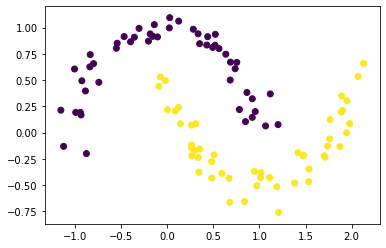

In [15]:
from sklearn.datasets import make_blobs, make_moons
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

x, y = make_moons(n_samples=100, noise=0.1)
plt.scatter(x[:,0], x[:,1], c = y)


## Задание

Напишите класс дерева, который реализует метод train, которая получает на вход матрицу данных ($x$) и целевые переменные ($y$), на выходе функция возвращает дерево в виде словаря в каждом случае записывается номер признака ($i$), порог разбиения($t$), значение в листовой вершине слева ($y_l$) и значение в листовой вершине справа ($y_r$). Вместо занчения в листовой вершине может содержаться следующий словарь с теми же ключами и так далее.

Необходимо учесть:

1. Возможность строить дерево строго определенной глубины и возможность указать максимальное количество объектов в листовой вершине.
2. Пороги разбиения должны лежать строго по середине между ближайшими обектами.
3. Разбиений не требуется, если в получившемся множестве находятся объекты одного класса.
4. Количество различных классов объектов в целевой переменной может быть больше двух.


In [16]:
def getGini(left, right, edge):
    allValues = left + right
    allValuesCount = float(len(allValues))
    allCategories = list(set([value[2] for value in allValues]))
    
    gini = 0.0
    for group in (left, right):
        groupLen = float(len(group))
        score = 0.0
        for category in allCategories:
            catRelation = [key[2] for key in group].count(category) / groupLen
            score += catRelation * catRelation

        gini += (1 - score) * (groupLen / allValuesCount)
    return gini

In [17]:
def calculateLoss(dimensionTuples, edge):
    left = []
    right = []
    
    for value in dimensionTuples:
        targetList = left if value[1] <= edge else right
        targetList.append(value)

    return getGini(left, right, edge)

In [18]:
def getDimensionEdge(positionsList, pointValues):
    # create tuples for dimension like (index, position, value)
    dimensionTuples = []
    for key, position in enumerate(positionsList):
        dimensionTuples.append((key, position, pointValues[key]))
    dimensionTuples.sort(key=lambda v: v[1])
    
    minGini, index = 1, -1
    for key in range(len(dimensionTuples) - 1):
        left = dimensionTuples[key]
        right = dimensionTuples[key + 1]
        edge = (left[1] + right[1]) / 2
        
        gini = calculateLoss(dimensionTuples, edge)
        if (gini < minGini):
            minGini, index = gini, key

    return minGini, dimensionTuples[index], dimensionTuples[index + 1];

In [19]:
def getLeaf(y):
    categoriesList = list(set(y));
    return -1 if len(categoriesList) > 1 else int(categoriesList[0])

In [20]:
def splitByEdge(x, y, dimension, edge):
    xTargets = {
        'x': [],
        'y': []
    }
    yTargets = {
        'x': [],
        'y': []
    }
    for key, values in enumerate(x):
        targets = xTargets if values[dimension] <= edge else yTargets
        targets['x'].append(values)
        targets['y'].append(y[key])

    return [xTargets, yTargets]

In [21]:
def getEdge(valuesSet):
    if(type(valuesSet) is int):
        return valuesSet
    
    x = valuesSet['x']
    y = valuesSet['y']
    
    leaf = getLeaf(y);
    
    if (not leaf == -1):
        return leaf;
    
    minDimensionKey, minGini, minLeft, minRight = -1, 1, 0, 0
    for dimensionKey in range(len(x[0])):
        dimensionValues = [values[dimensionKey] for values in x]
        gini, left, right = getDimensionEdge(dimensionValues, y)
        if (gini < minGini):
            minDimensionKey, minGini, minLeft, minRight = dimensionKey, gini, left, right
    
    edge = (minLeft[1] + minRight[1]) / 2
    
    left, right = splitByEdge(x, y, minDimensionKey, edge);
    leftLeaf = getLeaf(left['y'])
    rightLeaf = getLeaf(right['y'])
    
    return {
        'dimension': minDimensionKey,
        'edge': edge,
        'leftValue': minLeft[1],
        'rightValue': minRight[1],
        'gini': minGini,
        'left': left,
        'right': right,
    };

firstSplit = getEdge({
    'x': x,
    'y': y
})

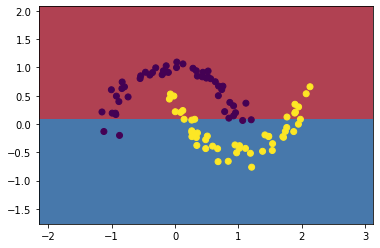

In [22]:
def tree_clf(x):
    y_pred = list()  
    for it in x.transpose():
        y_pred.append(1 if it[firstSplit['dimension']] <= firstSplit['edge'] else 0)
    return np.array(y_pred)

h = .02
x0_min, x0_max = np.min(x[:,0]) - 1, np.max(x[:,0]) + 1
x1_min, x1_max = np.min(x[:,1]) - 1, np.max(x[:,1]) + 1
xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h),
                         np.arange(x1_min, x1_max, h))

Z = tree_clf(np.stack((xx0.ravel(),xx1.ravel())))

Z = Z.reshape(xx0.shape)
cm = plt.cm.RdBu
plt.contourf(xx0, xx1, Z, cmap=cm, alpha=.8)
plt.scatter(x[:,0], x[:,1], c = y)


In [23]:
# decisionsTree:
# int or {
#     dimension: 1,
#     edge: 1.5,
#     left: 2, # particular leaf (int)
#     right: {...decisionsTree} # decisionsTree (dict)
# }
def categorizePoint(point, decisionTree):
    dimension = decisionTree['dimension']
    edge = decisionTree['edge']
    left = decisionTree['left']
    right = decisionTree['right']
    target = left if point[dimension] <= edge else right
    
    if (type(target) is dict):
        return categorizePoint(point, target);
    else:
        return target;

In [24]:
def categorizePoints(x, decisionTree):
    y_pred = list()  
    for it in x.transpose():
        y_pred.append(categorizePoint(it, decisionTree))
    return np.array(y_pred)

In [25]:
def printDecisionsTree(x, decisionTree):
    h = .02
    x0_min, x0_max = np.min(x[:,0]) - 1, np.max(x[:,0]) + 1
    x1_min, x1_max = np.min(x[:,1]) - 1, np.max(x[:,1]) + 1
    xx0, xx1 = np.meshgrid(np.arange(x0_min, x0_max, h),
                             np.arange(x1_min, x1_max, h))

    Z = categorizePoints(np.stack((xx0.ravel(),xx1.ravel())), decisionTree)

    Z = Z.reshape(xx0.shape)
    cm = plt.cm.RdBu
    plt.contourf(xx0, xx1, Z, cmap=cm, alpha=.8)
    plt.scatter(x[:,0], x[:,1], c = y)

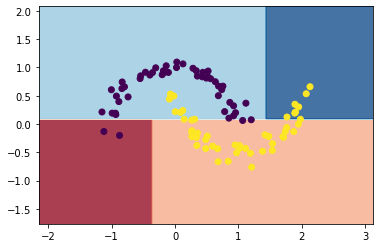

In [26]:
if (type(firstSplit['left']) is not int):
    firstSplit['left'] = getEdge(firstSplit['left'])
    firstSplit['left']['left'] = 30
    firstSplit['left']['right'] = 40

if (type(firstSplit['right']) is not int):
    firstSplit['right'] = getEdge(firstSplit['right'])
    firstSplit['right']['left'] = 50
    firstSplit['right']['right'] = 60

printDecisionsTree(x, firstSplit)

{'dimension': 1,
 'edge': 0.09419808561112256,
 'left': {'dimension': 0,
          'edge': -0.3658928291498136,
          'left': 0,
          'right': {'dimension': 1,
                    'edge': 0.02993412762831178,
                    'left': 1,
                    'right': {'dimension': 0,
                              'edge': 0.688820847267736,
                              'left': 1,
                              'right': {'dimension': 0,
                                        'edge': 1.5896864507591442,
                                        'left': 0,
                                        'right': 1}}}},
 'right': {'dimension': 0,
           'edge': 1.4417529577170876,
           'left': {'dimension': 1,
                    'edge': 0.567877201437434,
                    'left': {'dimension': 0,
                             'edge': 0.40305227575760805,
                             'left': {'dimension': 0,
                                      'edge': -0.41465946790912817,
  

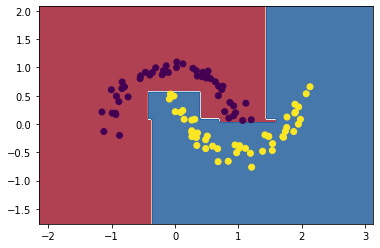

In [27]:
def getDesisionTree(valuesSet):
    decision = getEdge(valuesSet);
    
    if (type(decision) is int):
        return decision;
    else:
        return {
            'dimension': decision['dimension'],
            'edge': decision['edge'],
            'left': getDesisionTree(decision['left']),
            'right': getDesisionTree(decision['right']),
        }

tree = getDesisionTree({
    'x': x,
    'y': y,
})

import pprint
pprint.pprint(tree)

printDecisionsTree(x, tree)